# Predicting fuel consumption

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.optimize import least_squares

print("Tensorflow version:", tf.__version__)
print("Pytorch version:", torch.__version__)

Tensorflow version: 2.12.0
Pytorch version: 2.5.1+cpu


## Problem:

Choose a public database that represents a supervised classification or regression problem and using a single-hidden-layer MLP neural network:

1. Write a routine that loads the database and performs MLP training with k-fold cross-validation (use machine learning libraries and k=5).
2. Vary the number of neurons in the hidden layer seeking the best training result using the Backpropagation algorithm:
    * Perform 5 initializations of the training and display the results considering the mean value and standard deviation;
    * Depending on the problem chosen, the performance evaluation parameter may change, justify the choice of the parameter used;
    * Analyze the training curves -> Was there any overfitting? Justify.
3. With the model defined in item 2 (after choosing the number of neurons in the hidden layer), redo the training by modifying parameters of the training algorithm such as: batch size and learning rate.
4. with the model defined in item 2 (after choosing the number of neurons in the hidden layer), redo the training by modifying the training algorithm for Levemberg-Marquardt and R-PROP.

## Dataset

### Getting data

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

full_dataset = raw_dataset.copy()
full_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Cleaning data

In [4]:
full_dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
full_dataset = full_dataset.dropna()

In [6]:
origin = full_dataset.pop('Origin')
full_dataset['USA'] = (origin == 1)*1.0
full_dataset['Europe'] = (origin == 2)*1.0
full_dataset['Japan'] = (origin == 3)*1.0
full_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Analyzing distribution of data.

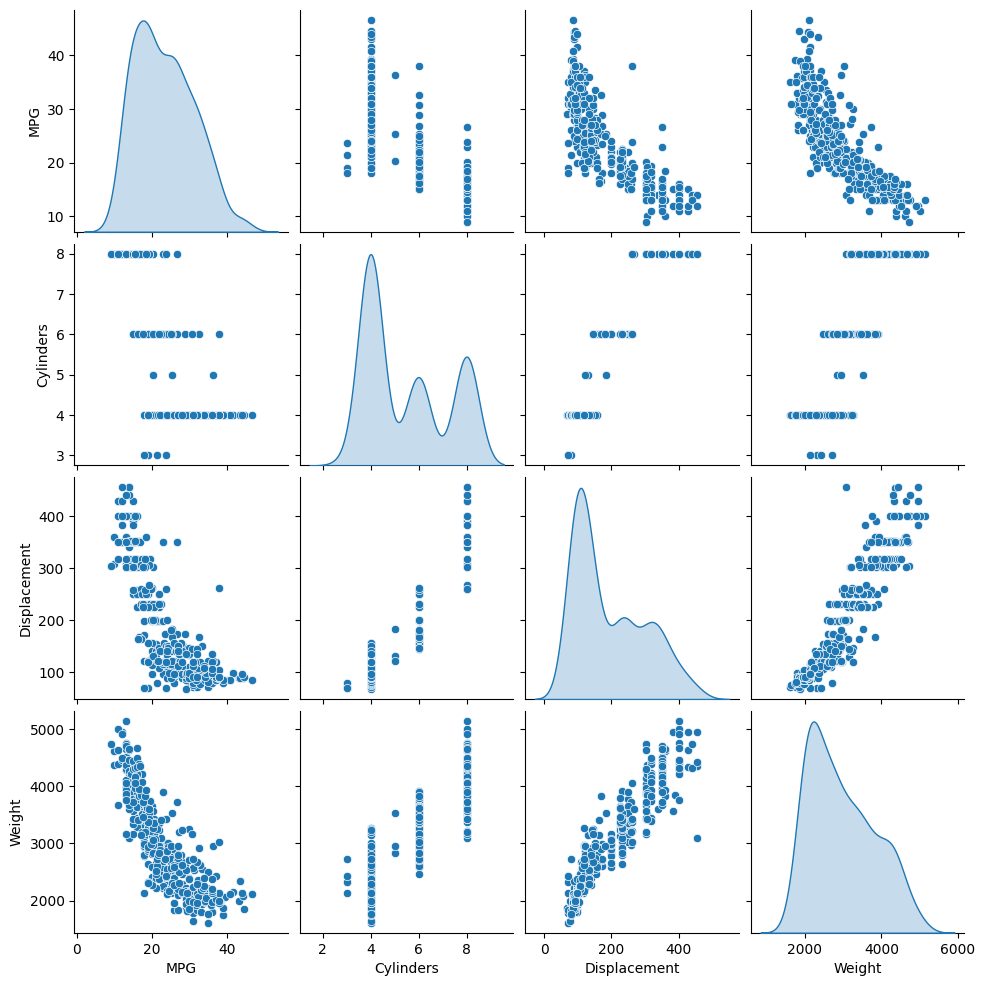

In [7]:
sns.pairplot(full_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

### Separating data

In [8]:
train_dataset = full_dataset.sample(frac=0.90, random_state=42)
test_dataset = full_dataset.drop(train_dataset.index)
train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

X = train_dataset
y = X.pop('MPG')

X_test = test_dataset
y_test = X_test.pop('MPG')

print(len(train_dataset))
print(len(test_dataset))

353
39


In [9]:
train_dataset.reset_index()

,index,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,0,4,96.0,69.0,2189.0,18.0,72,0.0,1.0,0.0
1,1,4,121.0,115.0,2795.0,15.7,78,0.0,1.0,0.0
2,2,4,91.0,60.0,1800.0,16.4,78,0.0,0.0,1.0
3,3,4,91.0,70.0,1955.0,20.5,71,1.0,0.0,0.0
4,4,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
348,348,8,302.0,140.0,4141.0,14.0,74,1.0,0.0,0.0
349,349,4,151.0,90.0,2556.0,13.2,79,1.0,0.0,0.0
350,350,4,107.0,75.0,2205.0,14.5,82,0.0,0.0,1.0
351,351,4,108.0,75.0,2265.0,15.2,80,0.0,0.0,1.0


In [10]:
stats = X.describe()
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,353.0,5.509915,1.724008,3.0,4.0,4.0,8.0,8.0
Displacement,353.0,196.862606,106.026028,68.0,105.0,151.0,302.0,455.0
Horsepower,353.0,106.031161,39.321976,46.0,76.0,95.0,130.0,230.0
Weight,353.0,2997.790368,857.112834,1613.0,2230.0,2830.0,3632.0,5140.0
Acceleration,353.0,15.445326,2.753332,8.0,13.5,15.5,17.0,24.8
Model Year,353.0,75.963173,3.687556,70.0,73.0,76.0,79.0,82.0
USA,353.0,0.623229,0.485264,0.0,0.0,1.0,1.0,1.0
Europe,353.0,0.169972,0.376141,0.0,0.0,0.0,0.0,1.0
Japan,353.0,0.206799,0.405585,0.0,0.0,0.0,0.0,1.0


### Normalization

In [11]:
norm = MinMaxScaler().fit(X)

X = pd.DataFrame(norm.transform(X), columns=X.columns)
X_test = pd.DataFrame(norm.transform(X_test), columns=X_test.columns)

In [12]:
def norm(x):
  stats = x.describe()
  stats = stats.transpose
  mean = stats['mean']
  std = stats['std']

  return (x - mean) / std

# normed_train_data = norm(dataset)

## Model

In [13]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

In [14]:
def get_model(neurons=10, input_shape=None, optimizer='Adam'):
    model = keras.models.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss="mse",
                  metrics=['mae', r2_metric])
    return model

## 1 - Cross validation KFold

Writing a routine that loads the database and performs MLP training with k-fold cross-validation (use machine learning libraries and k=5).

In [15]:
def make_dataset(X_data, y_data, n_splits):
    def gen():
        for train_index, test_index in KFold(n_splits).split(X_data):
            # Use `.iloc` se X_data ou y_data forem pandas DataFrame/Series
            X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
            y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]
            yield X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy()

    return tf.data.Dataset.from_generator(gen, (tf.float64, tf.float64, tf.float64, tf.float64))

dataset = make_dataset(X, y, 5)
dataset

<_FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [16]:
type(dataset)

tensorflow.python.data.ops.flat_map_op._FlatMapDataset

In [17]:
for fold, (X_train, y_train, X_val, y_val) in enumerate(dataset):
    print(f"Fold {fold + 1}:")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print()

Fold 1:
  X_train shape: (282, 9), y_train shape: (282,)
  X_val shape: (71, 9), y_val shape: (71,)

Fold 2:
  X_train shape: (282, 9), y_train shape: (282,)
  X_val shape: (71, 9), y_val shape: (71,)

Fold 3:
  X_train shape: (282, 9), y_train shape: (282,)
  X_val shape: (71, 9), y_val shape: (71,)

Fold 4:
  X_train shape: (283, 9), y_train shape: (283,)
  X_val shape: (70, 9), y_val shape: (70,)

Fold 5:
  X_train shape: (283, 9), y_train shape: (283,)
  X_val shape: (70, 9), y_val shape: (70,)



### Training functions

In [18]:
def train_kfold(dataset, neurons=5, epochs=100):
    models = []
    models_hist = {}
    final_metrics = {}

    for fold, (X_train, y_train, X_val, y_val) in enumerate(dataset):
        input_shape = X_train.shape[1:]  # Exclude the batch size
        
        model = get_model(input_shape=input_shape, neurons=neurons)
        print(f"Training fold number {fold}.")
        hist = model.fit(
            x=X_train, y=y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            verbose=0
        )

        # Saving model, history, and metrics
        models.append(model)
        models_hist[f'model_{fold}'] = hist
        
        for metric, values in hist.history.items():
            if metric not in final_metrics:
                final_metrics[metric] = []
            final_metrics[metric].append(values[-1])

    return models, models_hist, final_metrics

# models, models_hist, final_metrics = train_kfold(dataset)

In [19]:
# print("We will visualize:", list(models_hist['model_0'].history.keys()))

Plotting all the metrics

In [20]:
def plot_metrics(history_dict):
    # Separating training and validation metrics
    metrics = [key for key in history_dict.keys() if not key.startswith("val_")]
    val_metrics = ["val_" + metric for metric in metrics]
    
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(4 * num_metrics, 3))

    if num_metrics == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        sns.lineplot(data=history_dict[metric], label='Training ' + metric, ax=axs[i])
        sns.lineplot(data=history_dict[val_metrics[i]], label='Validation ' + metric, ax=axs[i])

        # Personalize each subplot
        axs[i].set_title(f"{metric.capitalize()} Over Epochs")
        axs[i].set_xlabel("Epoch")
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# for history in models_hist:
#     history_dict = models_hist[history].history
#     plot_metrics(history_dict)

## 2 - Training with diferrent neurons

Varying the number of neurons in the hidden layer to obtain the best training result using the Backpropagation algorithm:
 * perform 5 initializations of the training and display the results considering the average value and the standard deviation;
 * depending on the problem chosen, the performance evaluation parameter may change, justify the choice of the parameter used;
 * analyze the training curves -> was there any case of overfitting? Justify.

In [21]:
neurons_choices = [5, 25, 50, 100, 300]

I have chosen to analyze the MSE, MAE, and R2 metrics.

In [22]:
def print_metrics(metrics):
    print("Metrics (Mean ± Std):")    
    for metric, values in metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f". {metric}: {mean:.4f} ± {std:.4f}")
    print()

MODEL WITH 5 NEURONS
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


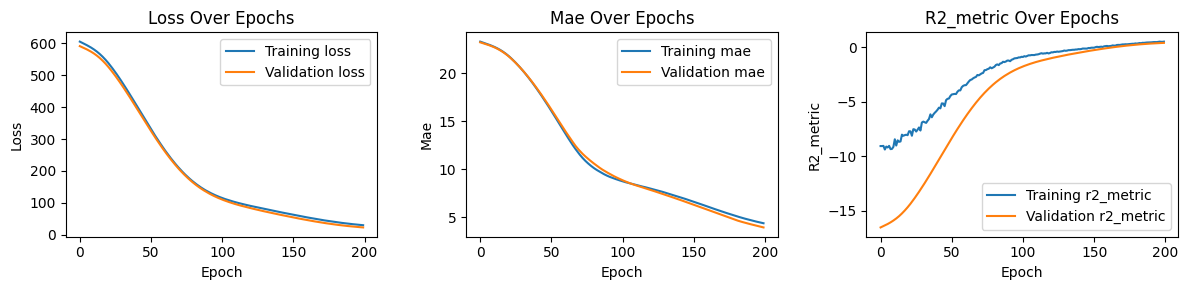

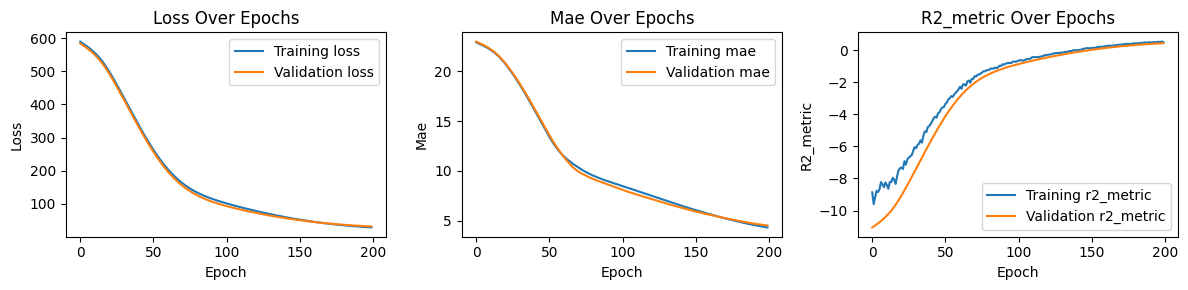

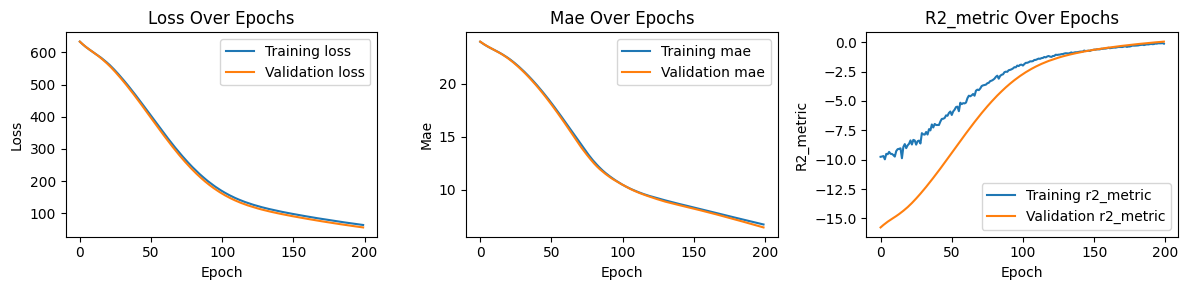

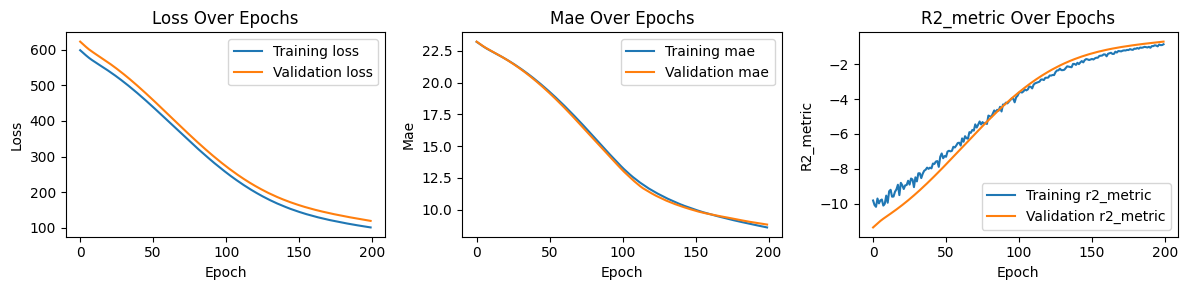

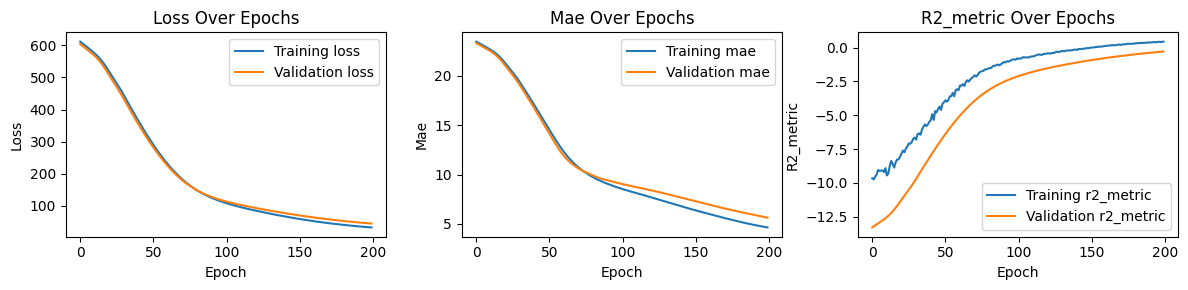

Metrics (Mean ± Std):
. loss: 51.3098 ± 28.0898
. mae: 5.7290 ± 1.6791
. r2_metric: 0.0973 ± 0.5269
. val_loss: 55.0419 ± 34.1859
. val_mae: 5.8678 ± 1.7082
. val_r2_metric: -0.0191 ± 0.4255

MODEL WITH 25 NEURONS
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


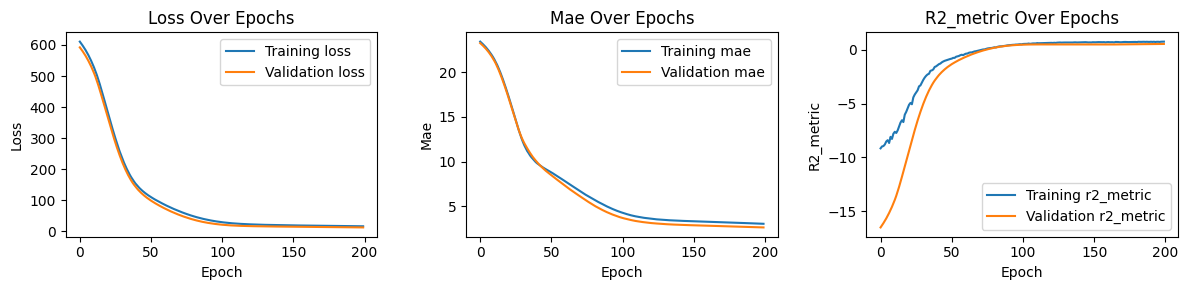

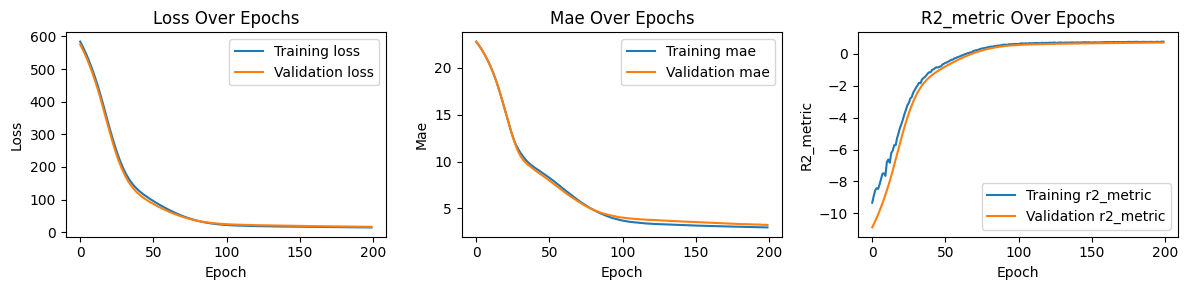

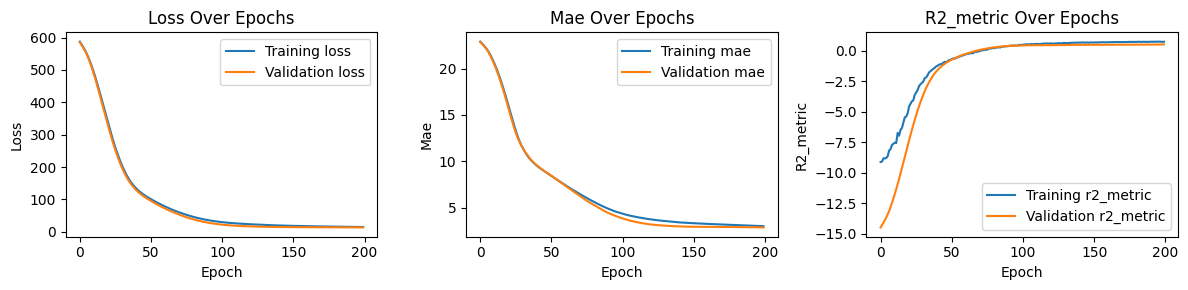

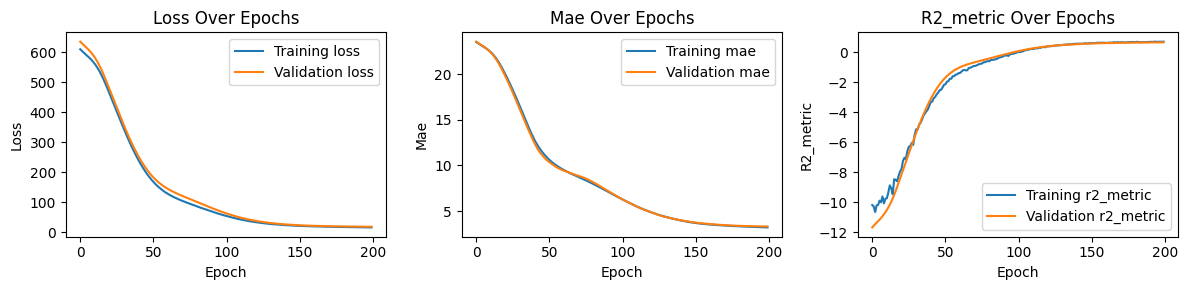

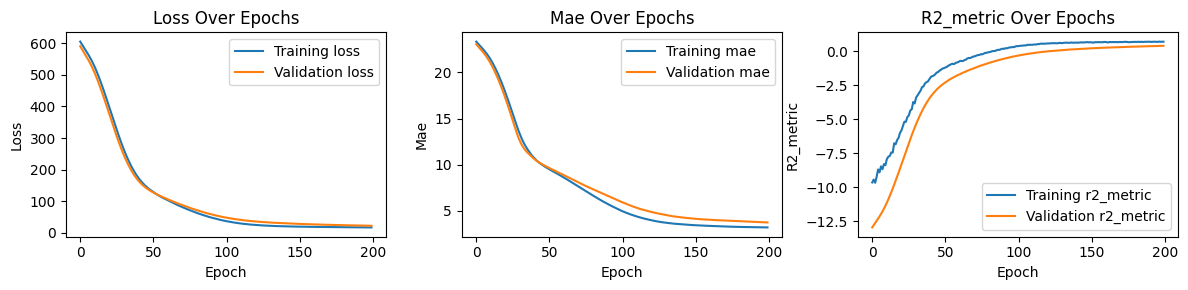

Metrics (Mean ± Std):
. loss: 15.5986 ± 0.9802
. mae: 3.0824 ± 0.1061
. r2_metric: 0.7349 ± 0.0250
. val_loss: 16.4963 ± 3.7807
. val_mae: 3.1556 ± 0.3877
. val_r2_metric: 0.5659 ± 0.1043

MODEL WITH 50 NEURONS
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


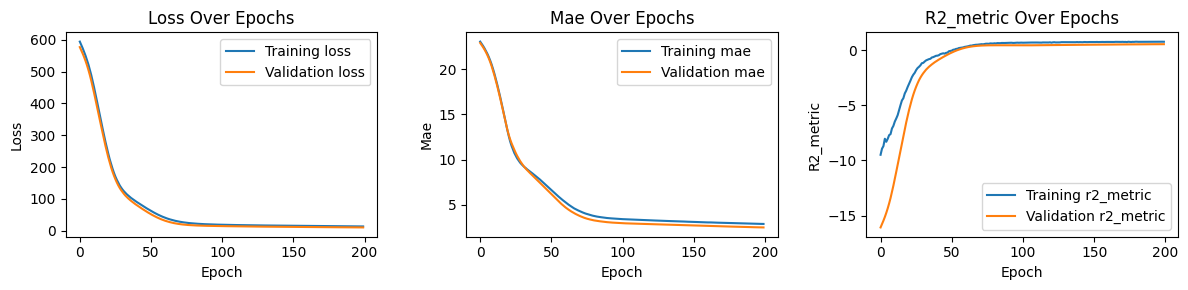

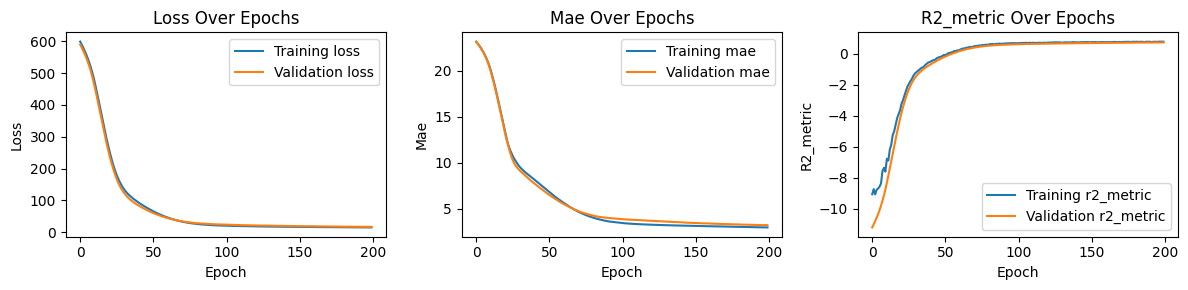

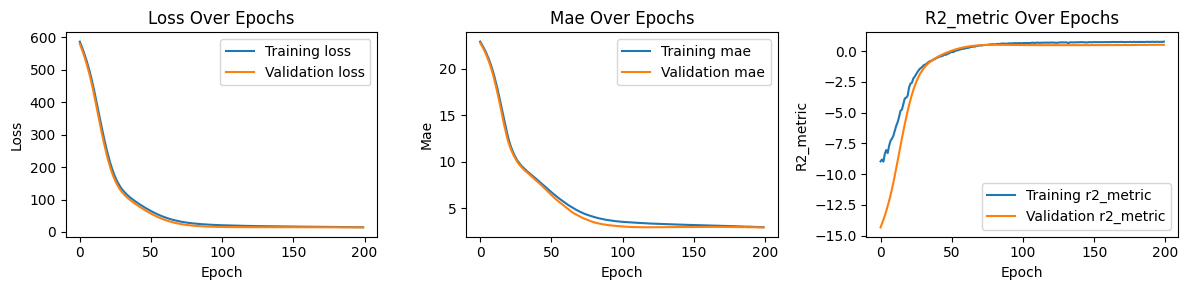

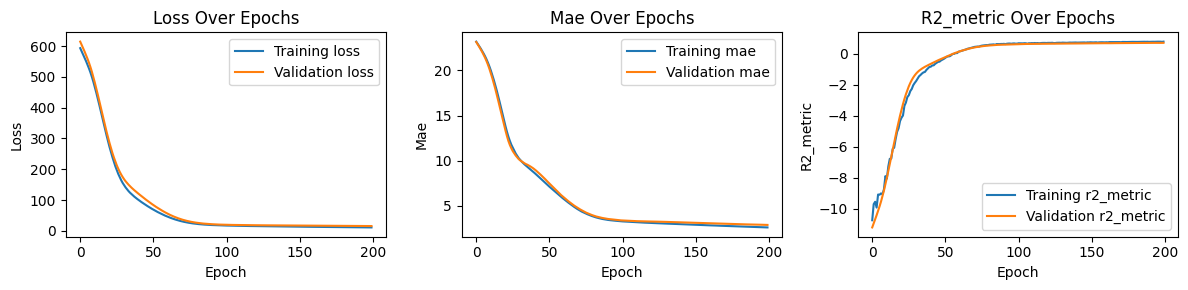

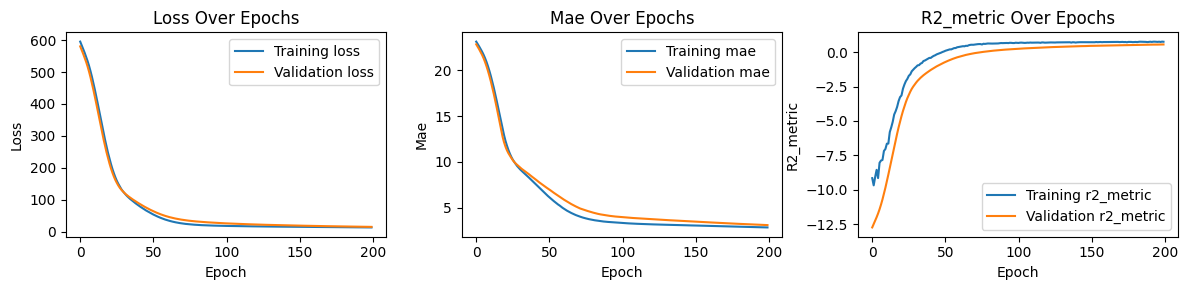

Metrics (Mean ± Std):
. loss: 13.5772 ± 1.2076
. mae: 2.8583 ± 0.1349
. r2_metric: 0.7697 ± 0.0135
. val_loss: 14.4245 ± 2.0719
. val_mae: 2.9310 ± 0.2472
. val_r2_metric: 0.6095 ± 0.0892

MODEL WITH 100 NEURONS
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


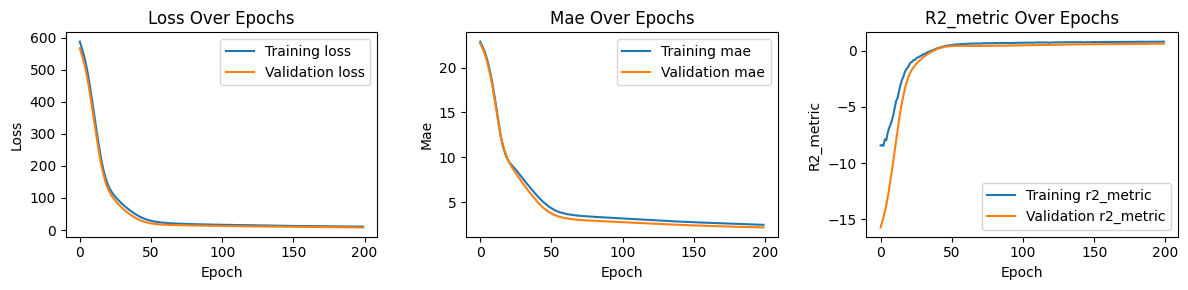

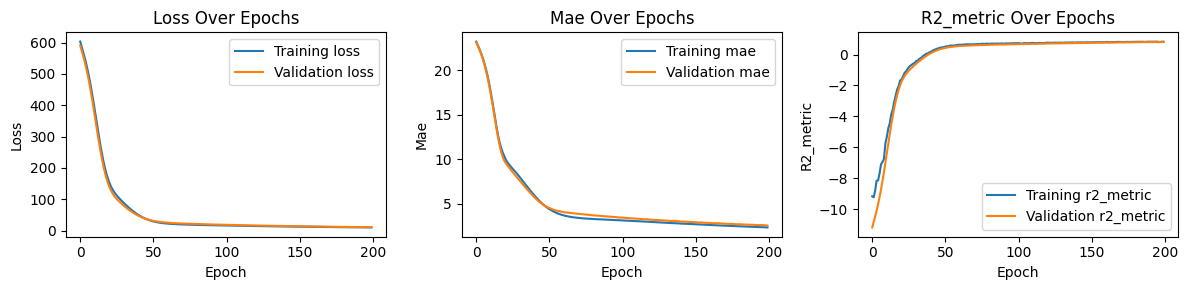

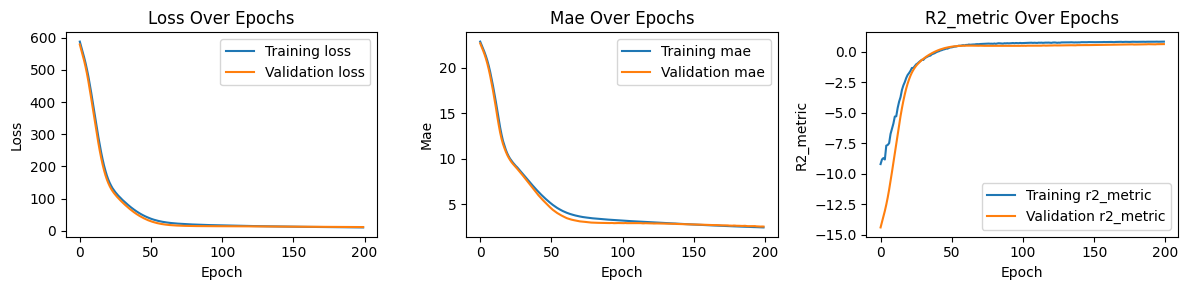

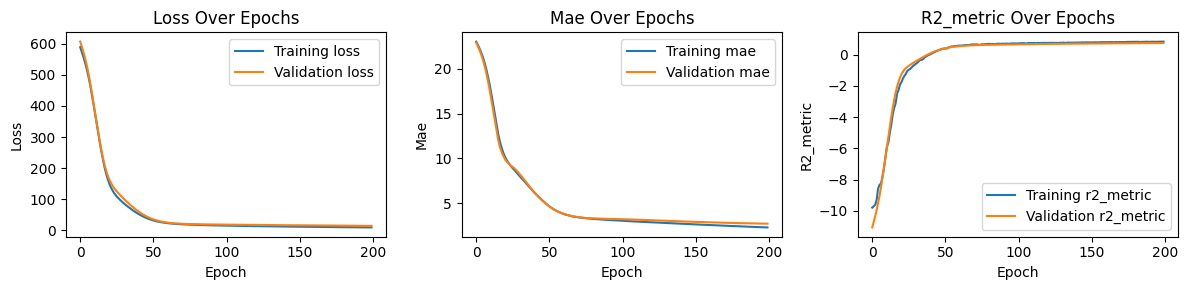

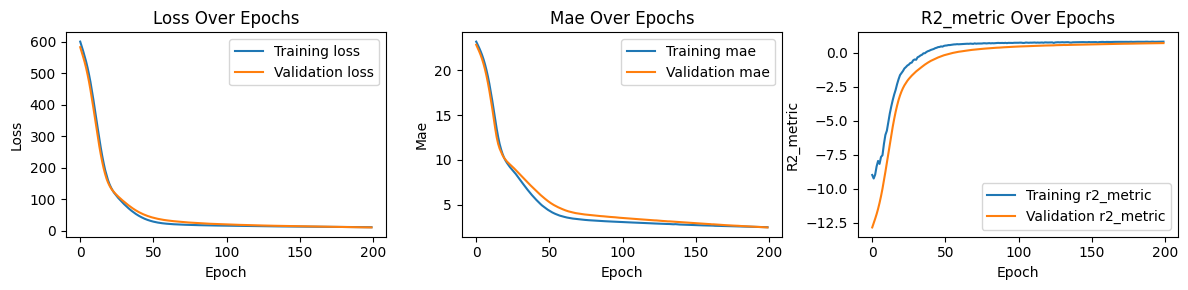

Metrics (Mean ± Std):
. loss: 10.1520 ± 0.5512
. mae: 2.3968 ± 0.0737
. r2_metric: 0.8277 ± 0.0049
. val_loss: 10.8633 ± 2.0171
. val_mae: 2.4796 ± 0.1726
. val_r2_metric: 0.7093 ± 0.0695

MODEL WITH 300 NEURONS
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


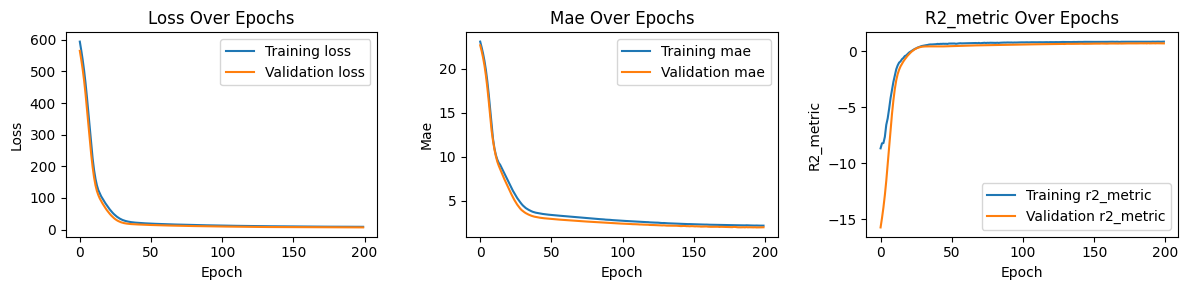

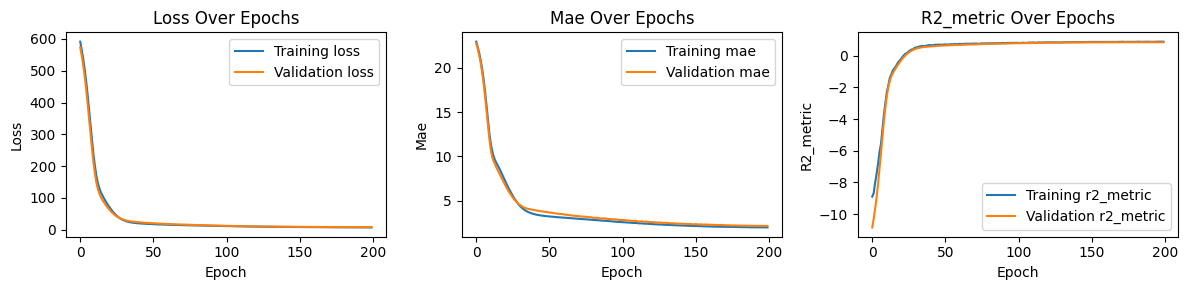

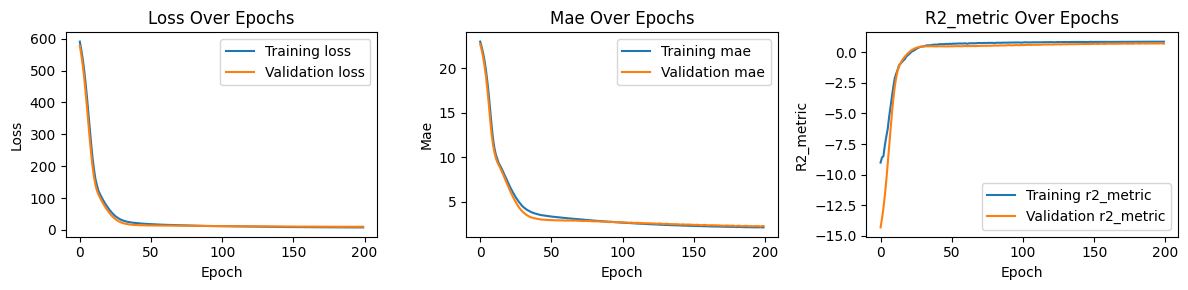

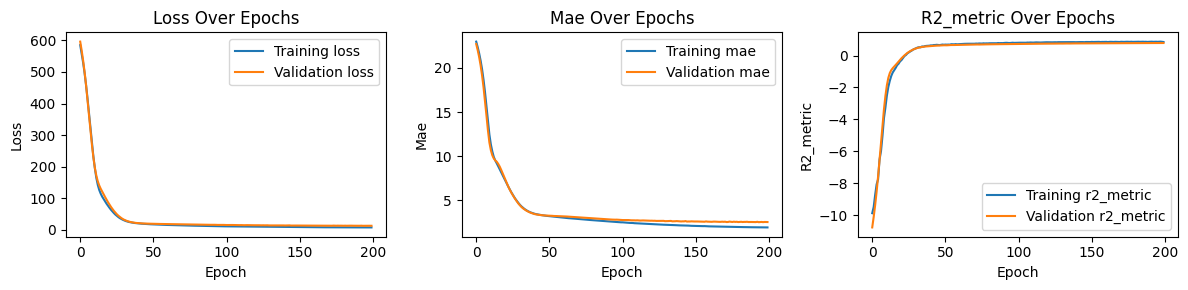

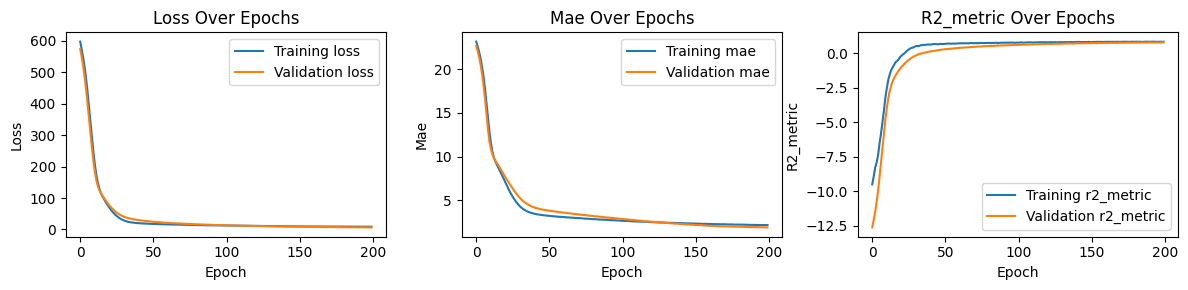

Metrics (Mean ± Std):
. loss: 7.9943 ± 0.6082
. mae: 2.0729 ± 0.0942
. r2_metric: 0.8620 ± 0.0083
. val_loss: 8.8871 ± 2.2106
. val_mae: 2.1664 ± 0.2289
. val_r2_metric: 0.7692 ± 0.0540



In [23]:
for neurons in neurons_choices:
    print("MODEL WITH", neurons, "NEURONS")
    models, models_hist, final_metrics = train_kfold(dataset, neurons=neurons, epochs=200)

    for history in models_hist:
        history_dict = models_hist[history].history
        plot_metrics(history_dict)
    
    print_metrics(final_metrics)

The model performs ok to solve the regression problem proposed. It didn't appear any of the models overfit.

Now we will see how it performs on the test dataset.

### Test data

In [ ]:
def find_best_score(metric='val_loss', evaluation='min'):
    # Find the best score and its index
    if evaluation=='min':
        best_score = min(final_metrics[metric])
    if evaluation=='max':
        best_score = max(final_metrics[metric])
    
    best_score_idx = final_metrics[metric].index(best_score)
    best_model = models[best_score_idx]
    
    print(f"Best {metric}: {best_score:.4f}, achieved by fold {best_score_idx}.")

    return best_model

def get_hidden_neurons(model):
    # The hidden layer is the first one
    dense_layer = model.layers[0]  # Get second layer
    return dense_layer.get_config()['units']  # Number of neurons

In [25]:
find_best_score('loss')
find_best_score('val_loss')
find_best_score('mae')
find_best_score('val_mae')
find_best_score('r2_metric', evaluation='max')
find_best_score('val_r2_metric', evaluation='max')

Best loss: 7.2281, achieved by fold 3.
Best val_loss: 6.5712, achieved by fold 4.
Best mae: 1.9460, achieved by fold 3.
Best val_mae: 1.9168, achieved by fold 4.
Best r2_metric: 0.8746, achieved by fold 1.
Best val_r2_metric: 0.8420, achieved by fold 1.


I will choose to get the best model based on the validation loss, which is the calculated with MSE.

In [26]:
best_model = find_best_score('val_loss')
best_neurons = get_hidden_neurons(best_model)
print("Best amount of neurons:", best_neurons)

Best val_loss: 6.5712, achieved by fold 4.
Best amount of neurons: 300


In [27]:
best_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 300)               3000      
                                                                 
 dense_49 (Dense)            (None, 1)                 301       
                                                                 
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


In [28]:
# for fold, history in models_hist.items():
#     history_dict = history.history  # Access history
#     print(f"Metrics for {fold}:")
#     plot_metrics(history_dict)

In [29]:
test_predictions = best_model.predict(X_test)
compare_results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': test_predictions.flatten()
})
compare_results_df

2/2 [==============================] - 0s 1ms/step


,Actual,Predicted
0,25.0,20.693123
1,24.0,20.933109
2,23.0,20.881855
3,30.0,27.077053
4,27.0,28.423349
5,23.0,28.865307
6,15.0,14.753074
7,14.0,15.234569
8,18.0,18.445164
9,11.0,12.148809


In [30]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def analyse_results_test(compare_results_df):
    r2_test = r2_score(compare_results_df['Actual'], compare_results_df['Predicted'])
    mse_test = mean_squared_error(compare_results_df['Actual'], compare_results_df['Predicted'])
    mae_test = mean_absolute_error(compare_results_df['Actual'], compare_results_df['Predicted'])

    print("Metrics results on test data:")
    print(f"R² Score:            {r2_test:.4f}")
    print(f"Mean Squared Error:  {mse_test:.4f}")
    print(f"Mean Absolute Error: {mae_test:.4f}")

analyse_results_test(compare_results_df)

Metrics results on test data:
R² Score:            0.8461
Mean Squared Error:  8.1840
Mean Absolute Error: 2.1591


## 3 - Retraining best model with modified parameters

With the model defined in item 2 (after choosing the number of neurons in the hidden layer), we will redo the training by modifying parameters of the training algorithm such as: batch size and learning rate.

The 'adam' optimizer users a default learning rate of 0.001. So, we will use 0.01.

I will also be using early stop.

In [31]:
# Setting inputs
input_shape = X.shape[1:]
epochs = 200
batch_size = 32 
learning_rate = 0.01

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 300)               3000      
                                                                 
 dense_51 (Dense)            (None, 1)                 301       
                                                                 
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________
None


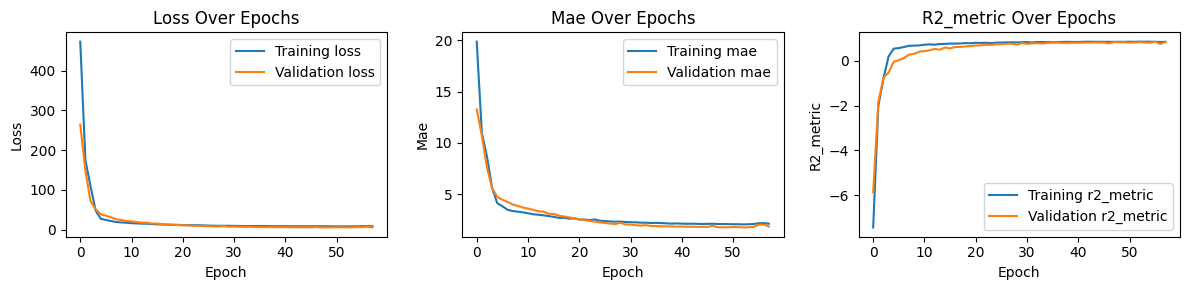

In [32]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

model = get_model(
    neurons=best_neurons,
    input_shape=input_shape,
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
)

print(model.summary())

hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callback,
    verbose=0
)

plot_metrics(hist.history)

In [33]:
test_predictions = model.predict(X_test)
compare_results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': test_predictions.flatten()
})
compare_results_df


2/2 [==============================] - 0s 1ms/step


,Actual,Predicted
0,25.0,20.331488
1,24.0,21.147352
2,23.0,21.956898
3,30.0,27.143698
4,27.0,29.047337
5,23.0,28.531353
6,15.0,15.592614
7,14.0,15.774728
8,18.0,19.669559
9,11.0,12.980112


In [34]:
analyse_results_test(compare_results_df)

Metrics results on test data:
R² Score:            0.8558
Mean Squared Error:  7.6704
Mean Absolute Error: 2.1796


## 4 - Levemberg-Marquardt and R-PROP

With the model defined in item 2 (after choosing the number of neurons in the hidden layer), redo the training by modifying the training algorithm for Levemberg-Marquardt and R-PROP.

For this section, I will be using Pytorch for its better adaptability to work with different optimizers.

### Levemberg-Marquardt

In [35]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_neurons=20):
        super(NeuralNet, self).__init__()
        self.hidden = torch.nn.Linear(input_dim, hidden_neurons) # 20 layers to be able to compute
        self.output = torch.nn.Linear(hidden_neurons, 1)
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)

In [36]:
# Function calculates difference between model prediction and actual target value
def residuals(model, X, y):
    y_pred = model(X).squeeze()
    return (y - y_pred).detach().numpy()

We will need auxiliar functions to get and set weights from model

In [37]:
def get_weights(model):
    weights = []
    for param in model.parameters():
        weights.append(param.data.numpy().flatten())  # Vectorized 
    return torch.tensor(np.concatenate(weights), requires_grad=True)

def set_weights(model, new_weights):
    start = 0
    for param in model.parameters():
        shape = param.data.shape
        size = param.numel()  # Total number of elements on tensor
        param.data = torch.tensor(new_weights[start:start+size].reshape(shape))
        start += size


In [38]:
# Levenberg-Marquardt
def train_with_lm(model, X, y):
    loss_history = []
    initial_weights = get_weights(model).detach().numpy()
    
    def loss_function(weights):
        set_weights(model, weights)  # Update weights
        return residuals(model, X, y)

    # Rodando o Levenberg-Marquardt
    result = least_squares(
        fun=loss_function,
        x0=initial_weights,
        method='lm',
        verbose=2
    )
     
    set_weights(model, result.x)
    
    return model, loss_history


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train.values)
y_train_torch = torch.tensor(y_train.values)

In [40]:
input_dim = X_train_torch.shape[1]  # Number of input features
model = NeuralNet(input_dim)

model, hist = train_with_lm(model, X_train_torch, y_train_torch)

`xtol` termination condition is satisfied.
Function evaluations 7346, initial cost 7.6644e+04, final cost 7.1553e+02, first-order optimality 6.16e+00.


Now analyzing results on test data and compare it with the best model trained with Adam.

In [41]:
X_test_torch = torch.tensor(X_test.values)
predictions = model(X_test_torch).detach().numpy().flatten()

compare_results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': predictions.flatten()
})

compare_results_df

,Actual,Predicted
0,25.5,27.253410
1,30.5,28.424091
2,14.0,13.468056
3,20.0,20.307165
4,13.0,13.608777
...,...,...
84,28.0,26.370569
85,14.0,13.519455
86,14.0,13.498743
87,18.0,22.085956


In [42]:
analyse_results_test(compare_results_df)

Metrics results on test data:
R² Score:            0.8663
Mean Squared Error:  9.3956
Mean Absolute Error: 2.1624


Even with lower amount of neurons, the model performed better and converged much faster then the standard Adam optimizer algorithm.

### R-Prop

In [43]:
model = NeuralNet(input_dim, hidden_neurons=best_neurons)
rprop_optimizer = torch.optim.Rprop(
    params=model.parameters()
)
loss_fn = torch.nn.MSELoss(reduction='mean')
epochs = 200

In [44]:
hist = []

for epoch in range(epochs):
    losses = []
    
    for X, y in zip(X_train_torch, y_train_torch):
        X = X.float()
        y = y.float()
        
        rprop_optimizer.zero_grad()

        # Forward pass
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        losses.append(loss.item())

        # Backward pass
        loss.backward()

        rprop_optimizer.step()

    avg_loss = sum(losses) / len(losses)
    hist.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Avg Loss: {avg_loss:.6f}")

d:\Code\Data Science\Projects\auto-mpg-prediction\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch   0 | Avg Loss: 123.337041
Epoch  10 | Avg Loss: 80.417302
Epoch  20 | Avg Loss: 79.399394
Epoch  30 | Avg Loss: 78.451669
Epoch  40 | Avg Loss: 77.539709
Epoch  50 | Avg Loss: 76.427110
Epoch  60 | Avg Loss: 75.643202
Epoch  70 | Avg Loss: 74.890387
Epoch  80 | Avg Loss: 74.217062
Epoch  90 | Avg Loss: 73.566067
Epoch 100 | Avg Loss: 72.943672
Epoch 110 | Avg Loss: 72.386488
Epoch 120 | Avg Loss: 71.860133
Epoch 130 | Avg Loss: 71.350242
Epoch 140 | Avg Loss: 70.857516
Epoch 150 | Avg Loss: 70.378535
Epoch 160 | Avg Loss: 69.938443
Epoch 170 | Avg Loss: 69.548745
Epoch 180 | Avg Loss: 69.164580
Epoch 190 | Avg Loss: 68.786974


<Axes: >

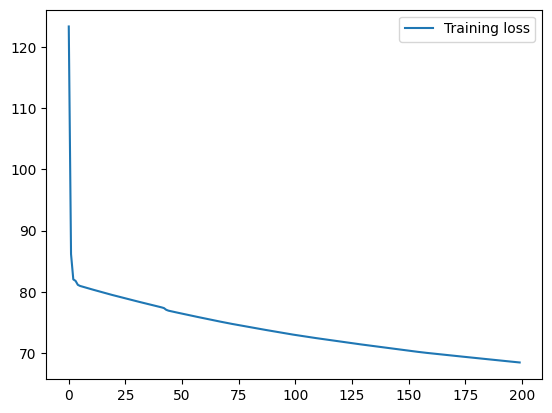

In [45]:
sns.lineplot(data=hist, label='Training loss')

The RProp clearly doesn't converge.

In [46]:
X_test_torch = torch.tensor(X_test.values, dtype=torch.float)
predictions = model(X_test_torch).detach().numpy().flatten()

compare_results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': predictions.flatten()
})

analyse_results_test(compare_results_df)

Metrics results on test data:
R² Score:            -0.0243
Mean Squared Error:  71.9901
Mean Absolute Error: 7.4560


The main problem is that the Rprop optimizer may not be the best choice for the task of neural network regression. This algorithm was designed for nonlinear optimization problems, but is generally better suited for smaller networks or problems where the derivatives may be inconsistent or highly variable. It does not use the magnitude of the gradient to update the weights, which can be problematic in deeper networks or networks with a lot of data.